In [1]:
# 1) Wipe out all Python variables
%reset -f
# 2) Force Python’s garbage collector to run
import gc
gc.collect()

import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["BLIS_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["OMP_WAIT_POLICY"] = "PASSIVE"

import importlib
from libs import trades, plots, params, models
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(models)

<module 'libs.models' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/models.py'>

In [2]:
# Turn off interactive plotting globally (we’ll manage our own display)
import matplotlib
import matplotlib.pyplot as plt
plt.ioff()

import pandas as pd
import numpy as np
import math

from pathlib import Path
import pickle
import datetime as dt
from datetime import datetime
from datetime import time

import seaborn as sns
from pprint import pprint

import torch
import torch.nn.functional as Funct
from torch.utils.data import Dataset, DataLoader
torch.serialization.add_safe_globals([models.DayWindowDataset])

from tqdm.auto import tqdm

import io
import json
from PIL import Image
import IPython.display as disp

import optuna
from optuna.trial import TrialState
from optuna.importance import get_param_importances
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.storages import RDBStorage

In [3]:
device               = params.device
ticker               = params.ticker
save_path            = params.save_path

sess_start           = params.sess_start
sess_end             = params.sess_end

n_trials = 200
n_jobs = 1

In [4]:
df_trainval = pd.read_csv(params.trainval_csv, index_col=0, parse_dates=True)
df_trainval

,open,high,low,close,volume,atr_14,ma_5,ma_20,ma_diff,macd_12_26,...,stoch_d_3,in_trading,hour,day_of_week,month,bid,ask,signal,pred_signal,pred_action
2004-01-02 14:00:00,-0.597963,-0.671685,-0.506250,-0.599867,1.488767,-1.402778,-0.599973,-0.670029,-1.242828e-13,-0.063516,...,-1.561625,0,0.247,-0.976,0.351,0.762810,0.763953,0.448429,0.219018,1
2004-01-02 14:01:00,-0.605900,-0.678633,-0.515625,-0.607830,1.524218,-1.402778,-0.608131,-0.678800,0.000000e+00,-0.064115,...,-1.561625,0,0.247,-0.976,0.351,0.762794,0.763936,0.488664,0.227014,1
2004-01-02 14:02:00,-0.613838,-0.685582,-0.525000,-0.615793,1.559669,-1.402778,-0.616288,-0.687570,0.000000e+00,-0.064671,...,-1.561625,0,0.247,-0.976,0.351,0.762777,0.763920,0.532508,0.231574,1
2004-01-02 14:03:00,-0.621775,-0.692530,-0.534375,-0.623756,1.595119,-1.402778,-0.624446,-0.696341,-1.242828e-13,-0.065186,...,-1.561625,0,0.247,-0.976,0.351,0.762760,0.763903,0.580285,0.239660,1
2004-01-02 14:04:00,-0.629713,-0.699479,-0.543750,-0.631719,1.630570,-1.402778,-0.632604,-0.705112,-1.242828e-13,-0.065663,...,-1.561625,0,0.247,-0.976,0.351,0.762743,0.763886,0.632348,0.250895,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-28 20:56:00,0.736230,0.747917,0.784043,0.790310,2.263197,0.652514,0.741828,0.738415,2.744130e-01,0.321477,...,1.211724,1,-0.939,0.973,0.979,175.238500,175.501500,0.318801,0.168294,1
2022-03-28 20:57:00,0.786714,0.797917,0.841489,0.822932,3.136585,0.765180,0.784641,0.743795,7.438394e-01,0.520116,...,1.289475,1,-0.939,0.973,0.979,175.316000,175.579200,0.224585,0.192748,1
2022-03-28 20:58:00,0.824577,0.839583,0.881915,0.880694,3.910116,0.836338,0.825969,0.753591,1.139913e+00,0.770887,...,1.438055,1,-0.939,0.973,0.979,175.453300,175.716700,0.008583,0.200804,1
2022-03-28 20:59:00,0.881372,0.897917,0.911702,0.882796,9.226442,0.943074,0.855498,0.762535,1.398787e+00,0.960884,...,1.284055,1,-0.939,0.973,0.979,175.458300,175.721700,0.000000,0.217608,1


In [5]:
# Flatten out pandas so we can index by numpy arrays
signals    = df_trainval["pred_signal"].to_numpy(dtype=float)
closes     = df_trainval["close"].to_numpy(dtype=float)
bids       = df_trainval["bid"].to_numpy(float)  
asks       = df_trainval["ask"].to_numpy(float)  
timestamps = df_trainval.index.to_numpy(dtype="datetime64[ns]")

# Build a list of (day, positions) for fast slicing
normed      = df_trainval.index.normalize().to_numpy(dtype="datetime64[ns]")
unique_days = np.unique(normed)
day_positions = [
    (day, np.flatnonzero(normed == day))
    for day in unique_days
]

In [6]:
def objective(trial):
    # 1) Suggest your hyperparameters
    pred_threshold     = trial.suggest_float("pred_threshold",     0.05, 0.95)
    trailing_stop_pred = trial.suggest_float("trailing_stop_pred", 0.01, 0.1)
    stats_list = []

    # 2) Loop day by day, report intermediate P&L to Optuna
    for step, (day, idxs) in enumerate(tqdm(day_positions, desc="Gen+Sim", leave=False), start=1):
        # Slice out one day of signals & closes
        df_day = pd.DataFrame(
            {
                "pred_signal": signals[idxs],
                "close"      : closes[idxs],
                "bid"        : bids[idxs],    
                "ask"        : asks[idxs]
            },
            index=pd.DatetimeIndex(timestamps[idxs])
        )

        # Generate actions and simulate
        df_actions = trades.generate_trade_actions(
            df               = df_day,
            col_signal       = "pred_signal",
            col_action       = "pred_action",
            buy_threshold    = pred_threshold,
            trailing_stop_pct= trailing_stop_pred,
            sess_start       = params.sess_start
        )
        one_day_res = trades.simulate_trading(
            results_by_day_sign={day: (df_actions, [])},
            col_action         ="pred_action",
            sess_start         = params.sess_start,
            sess_end           = params.sess_end,
            ticker             = params.ticker
        )

        # Extract stats
        _, _, stats = next(iter(one_day_res.values()))
        stats_list.append(stats)

        # Report day’s P&L for pruning (optional)
        day_pnl = stats["Strategy Return ($)"]
        trial.report(day_pnl, step)
        if trial.should_prune():
            raise optuna.TrialPruned()

    # 3) Aggregate metrics
    returns      = [s["Strategy Return ($)"] for s in stats_list]
    total_pnl    = sum(returns)
    avg_daily_pnl= total_pnl / len(returns) if returns else 0.0

    return avg_daily_pnl


[I 2025-08-25 10:50:34,794] A new study created in RDB with name: no-name-2422508f-d3ce-4d7c-96f9-d640a7d6483b


Gen+Sim:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-08-25 10:56:27,679] Trial 0 finished with value: -0.01931823132215207 and parameters: {'pred_threshold': 0.2767016676383925, 'trailing_stop_pred': 0.04061589670604261}. Best is trial 0 with value: -0.01931823132215207.


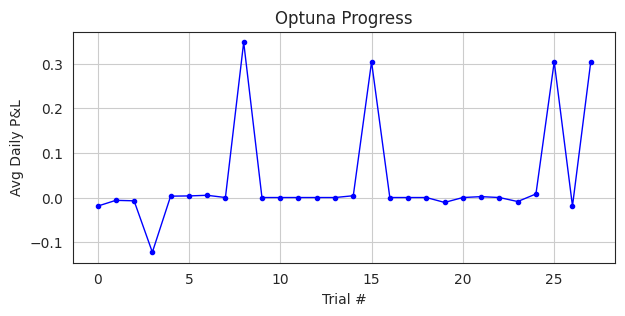

Gen+Sim:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-08-25 11:02:08,574] Trial 1 finished with value: -0.006322805489000182 and parameters: {'pred_threshold': 0.326017479568615, 'trailing_stop_pred': 0.0567797557050633}. Best is trial 1 with value: -0.006322805489000182.


Gen+Sim:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-08-25 11:07:51,330] Trial 2 finished with value: -0.007368547157482003 and parameters: {'pred_threshold': 0.334327750777924, 'trailing_stop_pred': 0.06801419472700902}. Best is trial 1 with value: -0.006322805489000182.


Gen+Sim:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-08-25 11:13:54,334] Trial 3 finished with value: -0.12256523633195388 and parameters: {'pred_threshold': 0.18541574525001603, 'trailing_stop_pred': 0.07224373847714283}. Best is trial 1 with value: -0.006322805489000182.


Gen+Sim:   0%|          | 0/4591 [00:00<?, ?it/s]

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7b3f144924b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 
[I 2025-08-25 11:19:56,196] Trial 4 finished with value: 0.0030705728599433636 and parameters: {'pred_threshold': 0.5378948616061014, 'trailing_stop_pred': 0.07261187294635023}. Best is trial 4 with value: 0.0030705728599433636.


Gen+Sim:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-08-25 11:25:41,599] Trial 5 finished with value: 0.0035828795469396695 and parameters: {'pred_threshold': 0.6851005774083047, 'trailing_stop_pred': 0.040989997426626706}. Best is trial 5 with value: 0.0035828795469396695.


Gen+Sim:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-08-25 11:25:48,266] Trial 6 pruned. 


Gen+Sim:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-08-25 11:25:49,175] Trial 7 pruned. 


Gen+Sim:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-08-25 11:27:32,993] Trial 8 pruned. 


Gen+Sim:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-08-25 11:27:33,959] Trial 9 pruned. 


Gen+Sim:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-08-25 11:27:34,868] Trial 10 pruned. 


Gen+Sim:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-08-25 11:27:35,735] Trial 11 pruned. 


Gen+Sim:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-08-25 11:27:36,630] Trial 12 pruned. 


Gen+Sim:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-08-25 11:27:37,563] Trial 13 pruned. 


Gen+Sim:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-08-25 11:27:38,638] Trial 14 pruned. 


Gen+Sim:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-08-25 11:28:18,761] Trial 15 pruned. 


Gen+Sim:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-08-25 11:28:19,592] Trial 16 pruned. 


Gen+Sim:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-08-25 11:28:20,492] Trial 17 pruned. 


Gen+Sim:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-08-25 11:28:21,384] Trial 18 pruned. 


Gen+Sim:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-08-25 11:28:22,414] Trial 19 pruned. 


Gen+Sim:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-08-25 11:28:23,293] Trial 20 pruned. 


Gen+Sim:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-08-25 11:28:30,871] Trial 21 pruned. 


Gen+Sim:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-08-25 11:28:31,717] Trial 22 pruned. 


Gen+Sim:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-08-25 11:28:32,624] Trial 23 pruned. 


Gen+Sim:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-08-25 11:28:39,363] Trial 24 pruned. 


Gen+Sim:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-08-25 11:29:16,872] Trial 25 pruned. 


Gen+Sim:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-08-25 11:29:17,760] Trial 26 pruned. 


Gen+Sim:   0%|          | 0/4591 [00:00<?, ?it/s]

[I 2025-08-25 11:29:58,456] Trial 27 pruned. 


Gen+Sim:   0%|          | 0/4591 [00:00<?, ?it/s]

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7b3f144924b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


UnboundLocalError: cannot access local variable 'frozen_trial' where it is not associated with a value

In [7]:
study = optuna.create_study(
    direction      = "maximize",
    pruner         = optuna.pruners.MedianPruner(n_startup_trials=6, n_warmup_steps=12),
    storage        = RDBStorage(
        url="sqlite:///optuna_study.db",
        engine_kwargs={"connect_args": {"timeout": 20, "check_same_thread": False}}
    ),
    load_if_exists = False
)

study.optimize(
    objective,
    n_trials          = n_trials,
    n_jobs            = n_jobs,
    callbacks=[plots.cleanup_callback, plots.lightweight_plot_callback],
    gc_after_trial    = True,
)


In [ ]:
# Final plots & JSON dump (unchanged)...
ax = plot_optimization_history(study)
ax.figure.set_size_inches(8, 4)
plt.show()

print("Best Parameters       :", study.best_params)
print("Best Average Daily P&L:", study.best_value)

importances = get_param_importances(study)
print("\nHyperparameter importances (higher ⇒ more impact):")
for name, score in sorted(importances.items(), key=lambda x: x[1], reverse=True):
    print(f"  {name:20s}: {score:.3f}")

first_day = df_trainval.index.normalize().min().strftime("%Y%m%d")
last_day  = df_trainval.index.normalize().max().strftime("%Y%m%d")
file_name = f"{params.ticker}_{first_day}-{last_day}_optuna_predsig_pars_{study.best_value}_{params.model_path}.json"
file_path = os.path.join(params.optuna_folder, file_name)

with open(file_path, "w") as f:
    json.dump({
        "best_params": study.best_params,
        "best_value" : study.best_value,
        "importances": importances,
        "trials": [
            {"number": t.number, "value": t.value, "params": t.params, "state": t.state.name}
            for t in study.trials
        ],
    }, f, indent=4)

print(f"\nOptuna results (and importances) saved to: {file_path}")